In [1]:
import torch
import tower
import numpy as np


In [2]:
class Cifar10Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        self.X, self.Y = tower.fetch_tfds_img_ds("cifar10", split)
        self.X = self.X.astype(np.float32)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [3]:
dss = {
    "cifar10": (
        Cifar10Dataset("train"),
        Cifar10Dataset("test")
    )
}
hps = {
    "batch_size": 2048,
    "epochs": 256,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}


In [4]:
train_dataloader = torch.utils.data.DataLoader(
    dss["cifar10"][0], batch_size=hps["batch_size"])
test_dataloader = torch.utils.data.DataLoader(
    dss["cifar10"][1], batch_size=hps["batch_size"])

for X, Y in test_dataloader:
    print(f"X \in {X.shape}")
    print(f"Y \in {Y.shape} of {Y.dtype}")
    break


X \in torch.Size([2048, 32, 32, 3])
Y \in torch.Size([2048]) of torch.int64


In [5]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(32**2*3, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(hps["device"])
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=10, bias=True)
  )
)


In [6]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(hps["device"]), y.to(hps["device"])

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(hps["device"]), y.to(hps["device"])
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"{(100*correct):>0.1f}% | {test_loss:>8f}")


In [7]:
%%time
for t in range(hps["epochs"]):
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


10.0% | 2.304859
10.0% | 2.304120
10.0% | 2.303400
10.0% | 2.302697
10.1% | 2.302011
10.2% | 2.301339
10.9% | 2.300681
11.6% | 2.300036
12.5% | 2.299404
13.1% | 2.298784
13.7% | 2.298176
13.7% | 2.297579
13.6% | 2.296992
13.4% | 2.296415
13.0% | 2.295848
12.6% | 2.295289
12.3% | 2.294739
12.0% | 2.294197
11.7% | 2.293662
11.5% | 2.293134
11.3% | 2.292614
11.1% | 2.292099
11.0% | 2.291591
10.8% | 2.291088
10.8% | 2.290592
10.7% | 2.290100
10.6% | 2.289613
10.6% | 2.289131
10.5% | 2.288654
10.5% | 2.288181
10.5% | 2.287713
10.4% | 2.287248
10.4% | 2.286786
10.4% | 2.286328
10.4% | 2.285873
10.3% | 2.285421
10.3% | 2.284973
10.3% | 2.284526
10.3% | 2.284083
10.3% | 2.283641
10.4% | 2.283202
10.4% | 2.282765
10.4% | 2.282330
10.4% | 2.281897
10.5% | 2.281465
10.5% | 2.281035
10.5% | 2.280607
10.5% | 2.280180
10.6% | 2.279754
10.6% | 2.279329
10.7% | 2.278906
10.8% | 2.278484
10.8% | 2.278063
10.8% | 2.277642
10.9% | 2.277223
11.1% | 2.276805
11.2% | 2.276387
11.2% | 2.275971
11.2% | 2.2755

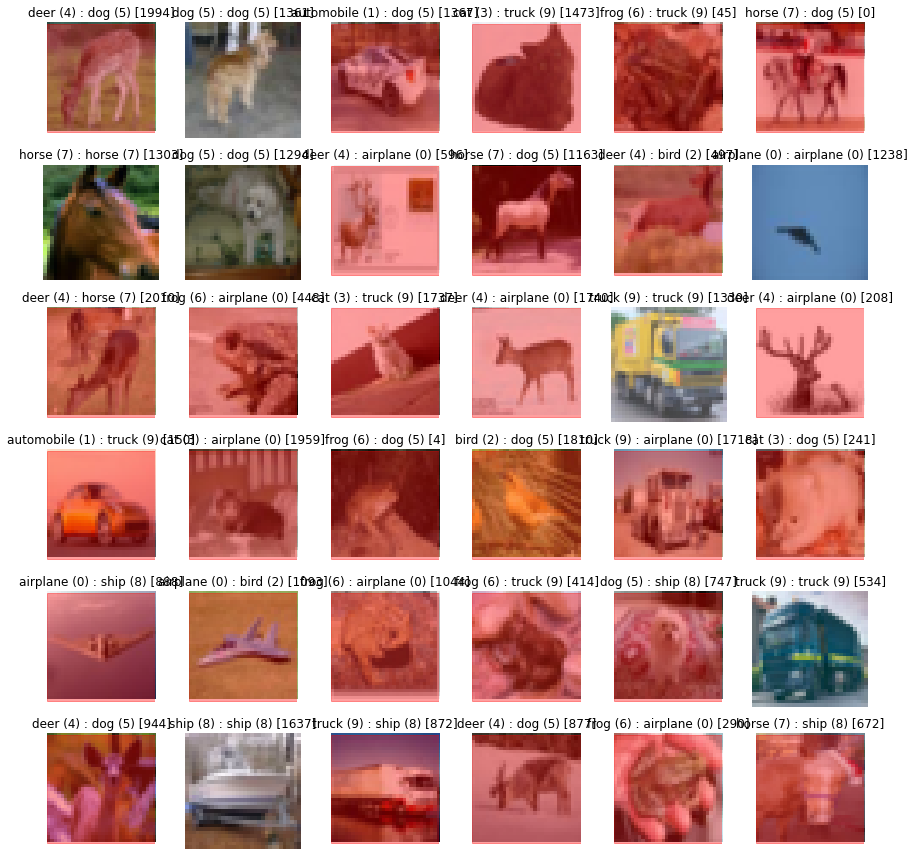

In [8]:
for X, Y in train_dataloader:
    pred = model(X.to(hps["device"])).argmax(axis=1).cpu()
    tower.show_img_ds(X, Y, pred, labels=tower.fetch_tfds_img_ds_labels("cifar10"), shape=(6, 6))
    break
